In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 1-Day Ahead Demand Forecasting

Predict `units_sold` for **1 day ahead** using proper time series methodology.

## Approach
- **Target**: 1-day ahead forecast (next day's units_sold)
- **Validation**: Walk-forward validation on time series
- **Baseline**: Naive forecast (today's value) and 7-day moving average
- **Models**: Ridge, Random Forest, XGBoost, LightGBM
- **Evaluation**: MAE, RMSE, MAPE on test set

## 1. Load Data

In [2]:
# Load the selected features with target
with zipfile.ZipFile('data/5_selected_features.zip', 'r') as zip_ref:
    with zip_ref.open('selected_features.csv') as csv_file:
        df = pd.read_csv(csv_file, low_memory=False)

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['product_id', 'location_id', 'date']).reset_index(drop=True)

print(f'Data loaded: {df.shape[0]:,} records × {df.shape[1]} columns')
print(f'Date range: {df["date"].min().date()} to {df["date"].max().date()}')
print(f'Products: {df["product_id"].nunique():,} | Locations: {df["location_id"].nunique():,}')
print(f'Product-Location pairs: {df.groupby(["product_id", "location_id"]).ngroups:,}')

# Verify target
assert 'target' in df.columns, 'Missing target column'
print(f'\nTarget stats: mean={df["target"].mean():.2f}, std={df["target"].std():.2f}')
print(f'[OK] Data loaded successfully')

Data loaded: 577,404 records × 37 columns
Date range: 2023-01-08 to 2024-01-29
Products: 67 | Locations: 107
Product-Location pairs: 1,492

Target stats: mean=6.02, std=24.67
[OK] Data loaded successfully


## 2. Prepare Features and Target

In [3]:
# Define feature columns (exclude identifiers, and target)
exclude_cols = ['date', 'location_id', 'product_id', 'target']
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f'Feature columns: {len(feature_cols)}')
print(f'Features: {feature_cols[:10]}...')

# Prepare X and y
X = df[feature_cols]
y = df['target']

print(f'\nX shape: {X.shape}')
print(f'y shape: {y.shape}')

Feature columns: 33
Features: ['units_sold', 'revenue', 'profit', 'units_sold_ema_7', 'units_sold_ema_14', 'units_sold_ema_3', 'epidemic', 'category_Groceries', 'category_Home & Furniture', 'units_sold_ma_30']...

X shape: (577404, 33)
y shape: (577404,)


## 3. Time-Based Train/Val/Test Split

We use chronological splitting to respect the temporal nature of the data:
- **Train**: First 70% of time period
- **Validation**: Next 15% of time period  
- **Test**: Final 15% of time period

Time-Based Split:
Train: 402,840 samples | 2023-01-08 to 2023-10-04
Val:   86,536 samples | 2023-10-05 to 2023-12-01
Test:  88,028 samples | 2023-12-02 to 2024-01-29


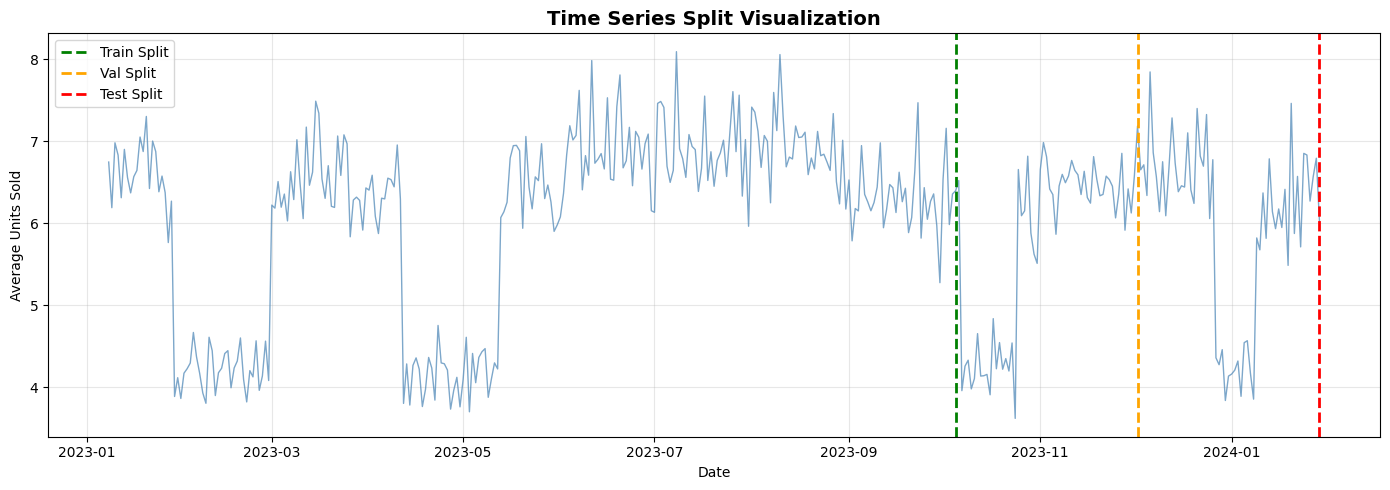

In [4]:
# Get unique sorted dates
unique_dates = sorted(df['date'].unique())
n_dates = len(unique_dates)

# Calculate split points
train_end_idx = int(n_dates * 0.70)
val_end_idx = int(n_dates * 0.85)

train_end_date = unique_dates[train_end_idx]
val_end_date = unique_dates[val_end_idx]

# Split data
train_mask = df['date'] < train_end_date
val_mask = (df['date'] >= train_end_date) & (df['date'] < val_end_date)
test_mask = df['date'] >= val_end_date

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

print('Time-Based Split:')
print(f'Train: {len(X_train):,} samples | {df[train_mask]["date"].min().date()} to {df[train_mask]["date"].max().date()}')
print(f'Val:   {len(X_val):,} samples | {df[val_mask]["date"].min().date()} to {df[val_mask]["date"].max().date()}')
print(f'Test:  {len(X_test):,} samples | {df[test_mask]["date"].min().date()} to {df[test_mask]["date"].max().date()}')

# Visualize split
fig, ax = plt.subplots(figsize=(14, 5))
daily_avg = df.groupby('date')['units_sold'].mean()
ax.plot(daily_avg.index, daily_avg.values, linewidth=1, color='steelblue', alpha=0.7)
ax.axvline(train_end_date, color='green', linestyle='--', linewidth=2, label='Train Split')
ax.axvline(val_end_date, color='orange', linestyle='--', linewidth=2, label='Val Split')
ax.axvline(unique_dates[-1], color='red', linestyle='--', linewidth=2, label='Test Split')
ax.set_title('Time Series Split Visualization', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Average Units Sold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Baseline Models

Before training ML models, we establish baseline performance using simple forecasting methods.

In [5]:
# Prepare validation dataframe for baseline calculations
val_df = df[val_mask].copy()

# Baseline 1: Naive forecast (use yesterday's value)
# For 1-day ahead, the naive forecast is just units_sold from yesterday
naive_pred = val_df['units_sold'].values
mae_naive = mean_absolute_error(y_val, naive_pred)
rmse_naive = np.sqrt(mean_squared_error(y_val, naive_pred))
r2_naive = r2_score(y_val, naive_pred)

# Baseline 2: 7-day moving average (if available in features)
if 'units_sold_ema_7' in feature_cols:
    ma7_pred = val_df['units_sold_ema_7'].fillna(val_df['units_sold']).values
    mae_ma7 = mean_absolute_error(y_val, ma7_pred)
    rmse_ma7 = np.sqrt(mean_squared_error(y_val, ma7_pred))
    r2_ma7 = r2_score(y_val, ma7_pred)
else:
    mae_ma7, rmse_ma7, r2_ma7 = None, None, None

print('BASELINE MODEL PERFORMANCE (on Validation Set)')
print(f'Naive Forecast (yesterday\'s value):')
print(f'  MAE={mae_naive:.3f}, RMSE={rmse_naive:.3f}, R²={r2_naive:.4f}')

if mae_ma7 is not None:
    print(f'\n7-Day Moving Average:')
    print(f'  MAE={mae_ma7:.3f}, RMSE={rmse_ma7:.3f}, R²={r2_ma7:.4f}')

BASELINE MODEL PERFORMANCE (on Validation Set)
Naive Forecast (yesterday's value):
  MAE=3.017, RMSE=12.923, R²=0.6820

7-Day Moving Average:
  MAE=2.447, RMSE=10.011, R²=0.8092


## 5. Train ML Models

We train multiple models and compare their performance.

In [6]:
# Dictionary to store results
results = []
models_dict = {}
predictions_dict = {}

print('TRAINING MACHINE LEARNING MODELS (evaluated on Validation Set)')

# Model 1: Ridge Regression
print('\n[1/4] Ridge Regression...')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_scaled, y_train)
pred_ridge = ridge.predict(X_val_scaled)

mae_ridge = mean_absolute_error(y_val, pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_val, pred_ridge))
r2_ridge = r2_score(y_val, pred_ridge)

results.append({'Model': 'Ridge', 'MAE': mae_ridge, 'RMSE': rmse_ridge, 'R²': r2_ridge})
models_dict['Ridge'] = (ridge, scaler)
predictions_dict['Ridge'] = pred_ridge
print(f'  MAE={mae_ridge:.3f}, RMSE={rmse_ridge:.3f}, R²={r2_ridge:.4f}')

# Model 2: Random Forest
print('\n[2/4] Random Forest...')
rf = RandomForestRegressor(
    n_estimators=20,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=4,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_val)

mae_rf = mean_absolute_error(y_val, pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_val, pred_rf))
r2_rf = r2_score(y_val, pred_rf)

results.append({'Model': 'Random Forest', 'MAE': mae_rf, 'RMSE': rmse_rf, 'R²': r2_rf})
models_dict['Random Forest'] = rf
predictions_dict['Random Forest'] = pred_rf
print(f'  MAE={mae_rf:.3f}, RMSE={rmse_rf:.3f}, R²={r2_rf:.4f}')

# Model 3: XGBoost
print('\n[3/4] XGBoost...')
xgb = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train, verbose=False)
pred_xgb = xgb.predict(X_val)

mae_xgb = mean_absolute_error(y_val, pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_val, pred_xgb))
r2_xgb = r2_score(y_val, pred_xgb)

results.append({'Model': 'XGBoost', 'MAE': mae_xgb, 'RMSE': rmse_xgb, 'R²': r2_xgb})
models_dict['XGBoost'] = xgb
predictions_dict['XGBoost'] = pred_xgb
print(f'  MAE={mae_xgb:.3f}, RMSE={rmse_xgb:.3f}, R²={r2_xgb:.4f}')

# Model 4: LightGBM
print('\n[4/4] LightGBM...')
lgbm = LGBMRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgbm.fit(X_train, y_train)
pred_lgbm = lgbm.predict(X_val)

mae_lgbm = mean_absolute_error(y_val, pred_lgbm)
rmse_lgbm = np.sqrt(mean_squared_error(y_val, pred_lgbm))
r2_lgbm = r2_score(y_val, pred_lgbm)

results.append({'Model': 'LightGBM', 'MAE': mae_lgbm, 'RMSE': rmse_lgbm, 'R²': r2_lgbm})
models_dict['LightGBM'] = lgbm
predictions_dict['LightGBM'] = pred_lgbm
print(f'  MAE={mae_lgbm:.3f}, RMSE={rmse_lgbm:.3f}, R²={r2_lgbm:.4f}')

TRAINING MACHINE LEARNING MODELS (evaluated on Validation Set)

[1/4] Ridge Regression...
  MAE=2.498, RMSE=9.796, R²=0.8173

[2/4] Random Forest...
  MAE=2.249, RMSE=9.359, R²=0.8332

[3/4] XGBoost...
  MAE=2.239, RMSE=9.376, R²=0.8326

[4/4] LightGBM...
  MAE=2.241, RMSE=9.341, R²=0.8339


## 6. Hyperparameter Tuning

We use the validation set to tune hyperparameters. This allows us to select the best hyperparameters without overfitting to the test set.

In [7]:
# Hyperparameter tuning using validation set
print('HYPERPARAMETER TUNING (using Validation Set)')
print(f'Training data size: {len(X_train):,} samples')
print(f'Validation data size: {len(X_val):,} samples\n')

# Tune LightGBM (current best model)
print('Tuning LightGBM...')
lgbm_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'num_leaves': [8, 16, 32],
    'learning_rate': [0.08, 0.1]
}

# Create all parameter combinations
from itertools import product
param_combinations = [dict(zip(lgbm_params.keys(), v)) for v in product(*lgbm_params.values())]

best_params = None
best_mae = float('inf')
tuning_results = []

print(f'Testing {len(param_combinations)} parameter combinations...\n')

for i, params in enumerate(param_combinations, 1):
    # Train model with these parameters
    lgbm_candidate = LGBMRegressor(**params, random_state=42, n_jobs=-1, verbose=-1)
    lgbm_candidate.fit(X_train, y_train)
    
    # Evaluate on validation set
    pred_val = lgbm_candidate.predict(X_val)
    mae_val = mean_absolute_error(y_val, pred_val)
    
    tuning_results.append({
        'params': params.copy(),
        'mae': mae_val
    })
    
    print(f'[{i}/{len(param_combinations)}] {params} -> MAE: {mae_val:.4f}')
    
    if mae_val < best_mae:
        best_mae = mae_val
        best_params = params.copy()

# Train final tuned model with best parameters
print(f'\nBest Parameters: {best_params}')
print(f'Best Validation MAE: {best_mae:.4f}')

lgbm_tuned = LGBMRegressor(**best_params, random_state=42, n_jobs=-1, verbose=-1)
lgbm_tuned.fit(X_train, y_train)
pred_lgbm_tuned = lgbm_tuned.predict(X_val)

mae_lgbm_tuned = mean_absolute_error(y_val, pred_lgbm_tuned)
rmse_lgbm_tuned = np.sqrt(mean_squared_error(y_val, pred_lgbm_tuned))
r2_lgbm_tuned = r2_score(y_val, pred_lgbm_tuned)

print(f'\nTuned LightGBM Performance (on Validation):')
print(f'  MAE:  {mae_lgbm_tuned:.3f} (original: {mae_lgbm:.3f})')
print(f'  RMSE: {rmse_lgbm_tuned:.3f} (original: {rmse_lgbm:.3f})')
print(f'  R²:   {r2_lgbm_tuned:.4f} (original: {r2_lgbm:.4f})')
improvement_lgbm = ((mae_lgbm - mae_lgbm_tuned) / mae_lgbm) * 100
print(f'  Improvement: {improvement_lgbm:.2f}%')

# Add tuned results to results list
results.append({'Model': 'LightGBM_Tuned', 'MAE': mae_lgbm_tuned, 'RMSE': rmse_lgbm_tuned, 'R²': r2_lgbm_tuned})
predictions_dict['LightGBM_Tuned'] = pred_lgbm_tuned
models_dict['LightGBM_Tuned'] = lgbm_tuned

HYPERPARAMETER TUNING (using Validation Set)
Training data size: 402,840 samples
Validation data size: 86,536 samples

Tuning LightGBM...
Testing 54 parameter combinations...

[1/54] {'n_estimators': 50, 'max_depth': 3, 'num_leaves': 8, 'learning_rate': 0.08} -> MAE: 2.2652
[2/54] {'n_estimators': 50, 'max_depth': 3, 'num_leaves': 8, 'learning_rate': 0.1} -> MAE: 2.2371
[3/54] {'n_estimators': 50, 'max_depth': 3, 'num_leaves': 16, 'learning_rate': 0.08} -> MAE: 2.2652
[4/54] {'n_estimators': 50, 'max_depth': 3, 'num_leaves': 16, 'learning_rate': 0.1} -> MAE: 2.2371
[5/54] {'n_estimators': 50, 'max_depth': 3, 'num_leaves': 32, 'learning_rate': 0.08} -> MAE: 2.2652
[6/54] {'n_estimators': 50, 'max_depth': 3, 'num_leaves': 32, 'learning_rate': 0.1} -> MAE: 2.2371
[7/54] {'n_estimators': 50, 'max_depth': 4, 'num_leaves': 8, 'learning_rate': 0.08} -> MAE: 2.2671
[8/54] {'n_estimators': 50, 'max_depth': 4, 'num_leaves': 8, 'learning_rate': 0.1} -> MAE: 2.2367
[9/54] {'n_estimators': 50, 'max

## 7. Model Comparison

In [8]:
# Create results dataframe
results_df = pd.DataFrame(results).sort_values('MAE')

# Add baselines
baseline_results = pd.DataFrame([
    {'Model': 'Naive (Baseline)', 'MAE': mae_naive, 'RMSE': rmse_naive, 'R²': r2_naive}
])
if mae_ma7 is not None:
    baseline_results = pd.concat([
        baseline_results,
        pd.DataFrame([{'Model': 'MA-7 (Baseline)', 'MAE': mae_ma7, 'RMSE': rmse_ma7, 'R²': r2_ma7}])
    ], ignore_index=True)

all_results = pd.concat([results_df, baseline_results], ignore_index=True).sort_values('MAE')

print('MODEL PERFORMANCE COMPARISON (on Validation Set)')
print(all_results.to_string(index=False))

# Find best model (excluding baselines)
best_model_name = results_df.iloc[0]['Model']
best_val_metrics = results_df.iloc[0]

print(f'\nBEST MODEL (based on Validation Set)')
print(f'Model: {best_model_name}')
print(f'MAE:   {best_val_metrics["MAE"]:.3f}')
print(f'RMSE:  {best_val_metrics["RMSE"]:.3f}')
print(f'R²:    {best_val_metrics["R²"]:.4f}')

# Improvement over baseline
improvement_pct = ((mae_ma7 - best_val_metrics['MAE']) / mae_ma7) * 100
print(f'\nImprovement over EMA-7 baseline: {improvement_pct:.1f}%')

MODEL PERFORMANCE COMPARISON (on Validation Set)
           Model      MAE      RMSE       R²
  LightGBM_Tuned 2.212670  9.333232 0.834147
         XGBoost 2.239101  9.375700 0.832634
        LightGBM 2.241014  9.340867 0.833875
   Random Forest 2.249439  9.359217 0.833222
 MA-7 (Baseline) 2.447228 10.011097 0.809181
           Ridge 2.497566  9.796070 0.817290
Naive (Baseline) 3.017137 12.922620 0.682049

BEST MODEL (based on Validation Set)
Model: LightGBM_Tuned
MAE:   2.213
RMSE:  9.333
R²:    0.8341

Improvement over EMA-7 baseline: 9.6%


## 8. Visualizations

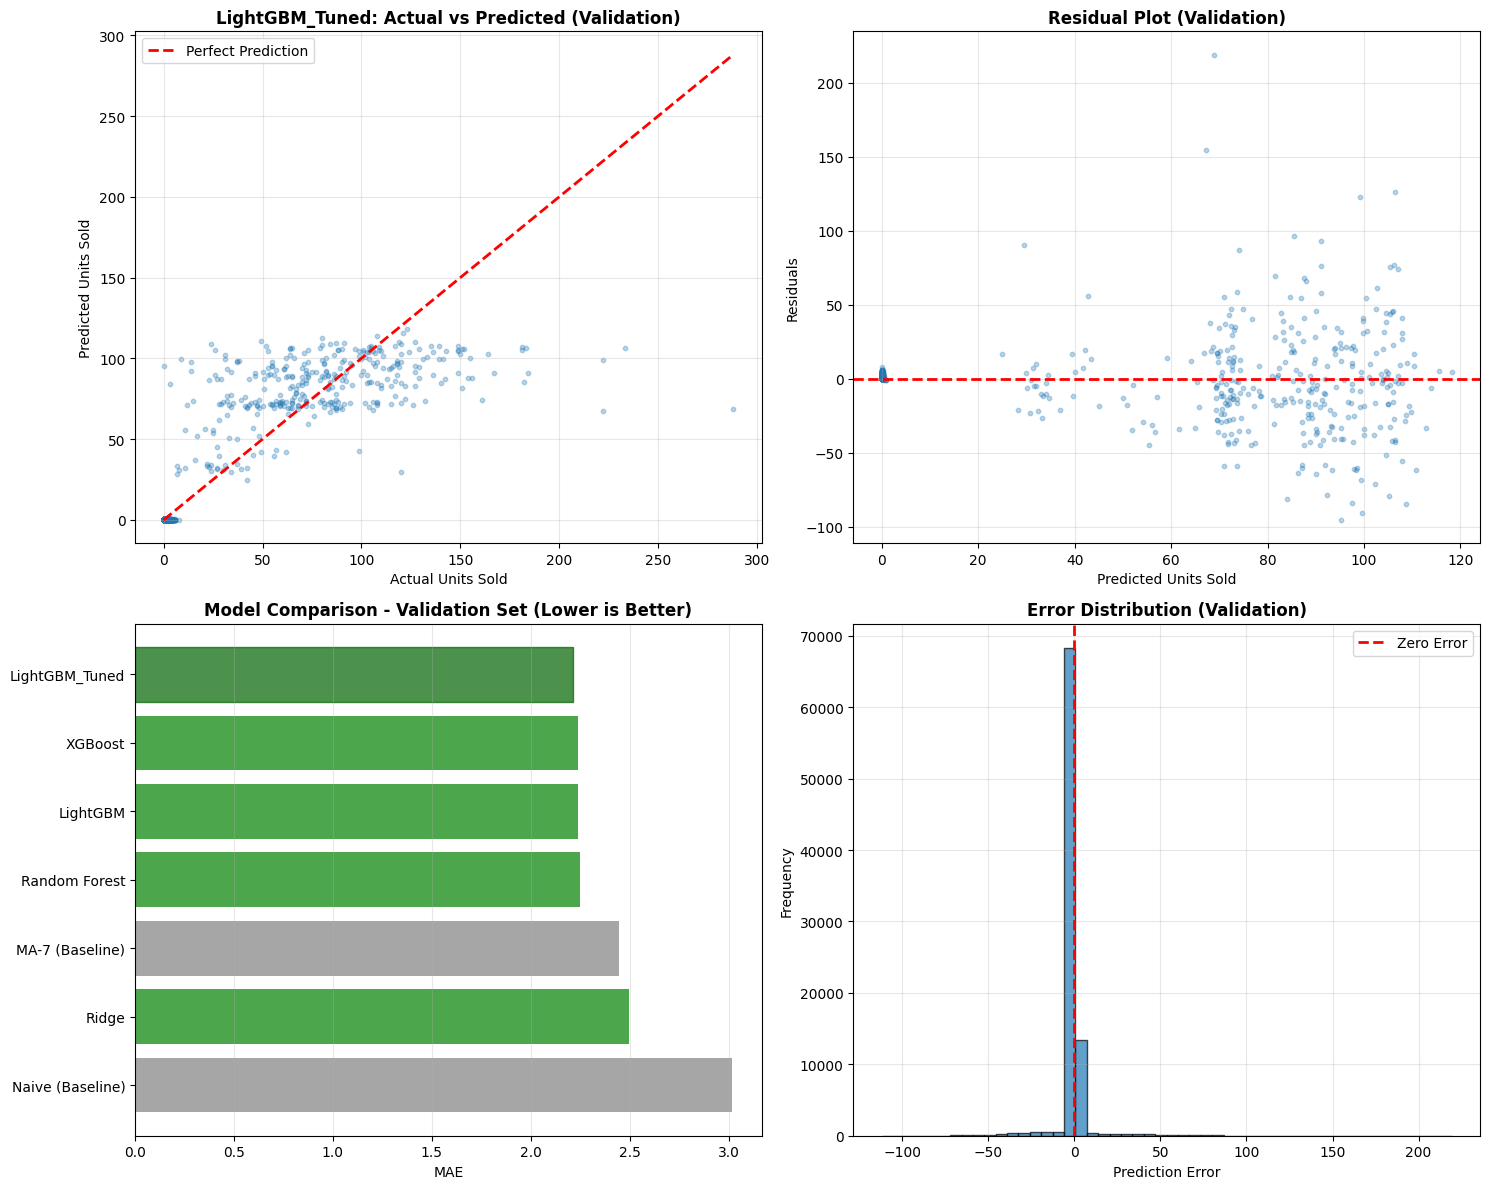

In [9]:
# Get best model predictions (on validation set)
y_pred_best = predictions_dict[best_model_name]

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted scatter
ax1 = axes[0, 0]
sample_size = min(5000, len(y_val))
indices = np.random.choice(len(y_val), sample_size, replace=False)
ax1.scatter(y_val.iloc[indices], y_pred_best[indices], alpha=0.3, s=10)
ax1.plot([0, y_val.max()], [0, y_val.max()], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Units Sold')
ax1.set_ylabel('Predicted Units Sold')
ax1.set_title(f'{best_model_name}: Actual vs Predicted (Validation)', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Residuals plot
ax2 = axes[0, 1]
residuals = y_val.iloc[indices] - y_pred_best[indices]
ax2.scatter(y_pred_best[indices], residuals, alpha=0.3, s=10)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Units Sold')
ax2.set_ylabel('Residuals')
ax2.set_title('Residual Plot (Validation)', fontweight='bold')
ax2.grid(alpha=0.3)

# 3. Model comparison bar chart
ax3 = axes[1, 0]
models = all_results['Model'].values
maes = all_results['MAE'].values
colors = ['green' if 'Baseline' not in m else 'gray' for m in models]
bars = ax3.barh(models, maes, color=colors, alpha=0.7)
bars[0].set_color('darkgreen')  # Highlight best model
ax3.set_xlabel('MAE')
ax3.set_title('Model Comparison - Validation Set (Lower is Better)', fontweight='bold')
ax3.grid(axis='x', alpha=0.3)
ax3.invert_yaxis()

# 4. Error distribution
ax4 = axes[1, 1]
errors = y_val.values - y_pred_best
ax4.hist(errors, bins=50, edgecolor='black', alpha=0.7)
ax4.axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
ax4.set_xlabel('Prediction Error')
ax4.set_ylabel('Frequency')
ax4.set_title('Error Distribution (Validation)', fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Final Model Training and Test Set Evaluation

Now that we've selected the best model using the validation set, we retrain it on the combined train+validation data and evaluate it **only once** on the test set to get the final performance metrics.

In [10]:
# Combine train and validation sets for final model training
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

print('FINAL MODEL TRAINING')
print(f'Selected best model: {best_model_name}')
print(f'Training on combined train+val data: {len(X_train_val):,} samples')
print(f'Test set size: {len(X_test):,} samples\n')

# Get the best model's hyperparameters
if best_model_name == 'LightGBM_Tuned':
    # Use the tuned hyperparameters
    final_model = LGBMRegressor(**best_params, random_state=42, n_jobs=-1, verbose=-1)
elif best_model_name == 'LightGBM':
    final_model = LGBMRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

# Train final model 
print(f'Training {best_model_name} on train+val data...')
final_model.fit(X_train_val, y_train_val)
y_pred_test = final_model.predict(X_test)

# Evaluate on test set (ONLY ONCE!)
print('\nFINAL TEST SET EVALUATION (used only once)')

test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)

# Also calculate baseline on test set for comparison
test_df = df[test_mask].copy()
ma7_pred_test = test_df['units_sold_ema_7'].fillna(test_df['units_sold']).values
test_ma7 = mean_absolute_error(y_test, ma7_pred_test)

print(f'\nModel: {best_model_name}')
print(f'Test MAE:   {test_mae:.3f} units')
print(f'Test RMSE:  {test_rmse:.3f} units')
print(f'Test R²:    {test_r2:.4f}')

print(f'\nBaseline (Naive) Test MAE: {test_ma7:.3f} units')
test_improvement = ((test_ma7 - test_mae) / test_ma7) * 100
print(f'Improvement over baseline: {test_improvement:.1f}%')

# Store final model results
final_model_package = {
    'model': final_model,
    'model_name': best_model_name,
    'feature_cols': feature_cols,
    'val_metrics': {
        'MAE': float(best_val_metrics['MAE']),
        'RMSE': float(best_val_metrics['RMSE']),
        'R2': float(best_val_metrics['R²'])
    },
    'test_metrics': {
        'MAE': float(test_mae),
        'RMSE': float(test_rmse),
        'R2': float(test_r2)
    },
    'test_baseline_mae': float(test_ma7),
    'test_improvement_pct': float(test_improvement)
}

print('\n[OK] Final model trained and evaluated on test set!')

FINAL MODEL TRAINING
Selected best model: LightGBM_Tuned
Training on combined train+val data: 489,376 samples
Test set size: 88,028 samples

Training LightGBM_Tuned on train+val data...

FINAL TEST SET EVALUATION (used only once)

Model: LightGBM_Tuned
Test MAE:   2.262 units
Test RMSE:  9.807 units
Test R²:    0.8369

Baseline (Naive) Test MAE: 2.453 units
Improvement over baseline: 7.8%

[OK] Final model trained and evaluated on test set!


## 11. Save Results and Models

In [11]:
# Save validation results
all_results.to_csv('data/6_model_results_validation.csv', index=False)
print('[OK] Validation results saved to: data/6_model_results_validation.csv')

# Save final test results
test_results_df = pd.DataFrame([{
    'Model': best_model_name,
    'Val_MAE': float(best_val_metrics['MAE']),
    'Val_RMSE': float(best_val_metrics['RMSE']),
    'Val_R²': float(best_val_metrics['R²']),
    'Test_MAE': test_mae,
    'Test_RMSE': test_rmse,
    'Test_R²': test_r2,
    'Baseline_Test_MAE': test_ma7,
    'Improvement_pct': test_improvement
}])
test_results_df.to_csv('data/6_model_results_test.csv', index=False)
print('[OK] Final test results saved to: data/6_model_results_test.csv')

# Summary
print('FINAL SUMMARY')
print(f'\nBest Model: {best_model_name}')
print(f'\nValidation Performance:')
print(f'  MAE:  {best_val_metrics["MAE"]:.3f} units')
print(f'  RMSE: {best_val_metrics["RMSE"]:.3f} units')
print(f'  R²:   {best_val_metrics["R²"]:.4f}')

print(f'\nFinal Test Performance (evaluated only once):')
print(f'  MAE:  {test_mae:.3f} units')
print(f'  RMSE: {test_rmse:.3f} units')
print(f'  R²:   {test_r2:.4f}')

print(f'\nBaseline (Naive) Test MAE: {test_ma7:.3f} units')
print(f'Improvement over baseline: {test_improvement:.1f}%')

[OK] Validation results saved to: data/6_model_results_validation.csv
[OK] Final test results saved to: data/6_model_results_test.csv
FINAL SUMMARY

Best Model: LightGBM_Tuned

Validation Performance:
  MAE:  2.213 units
  RMSE: 9.333 units
  R²:   0.8341

Final Test Performance (evaluated only once):
  MAE:  2.262 units
  RMSE: 9.807 units
  R²:   0.8369

Baseline (Naive) Test MAE: 2.453 units
Improvement over baseline: 7.8%
